# **1. Data Setup**

In [2]:
# Import libraries
import warnings
import os
import json
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.patches import Patch
from tqdm import tqdm
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

warnings.filterwarnings("ignore")
print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/halleluyamengesha/Desktop/UChicago/_Quarter_3/Computer_Vision/Project


## **2. Create Semantic Segmentation Masks**

- Parsed train-00 and test-00 annotations (COCO-style .json)

- Created pixel-level semantic masks for 31 architectural categories (e.g., bed, wall, toilet)

- Each object instance was assigned a category ID on a blank mask using polygons

- **Purpose:**
    - **To know what objects are in the scene and where they are — pixel-wise.**

In [3]:
# configurations
BASE_DIR    = "/Users/halleluyamengesha/Desktop/UChicago/_Quarter_3/Computer_Vision/Project/data/cad_dataset"
SPLIT       = "train-00"                              # change to train-01 or test-00 as needed
NUM_CLASSES = 32                                      # 0 = background, 1–31 semantic classes
N_DISPLAY   = 3                                       # how many samples to visualize

# paths
ann_path  = os.path.join(BASE_DIR, "annotations", f"{SPLIT}-annotations.json")
img_dir   = os.path.join(BASE_DIR, "images",      SPLIT)
mask_dir  = os.path.join(BASE_DIR, "masks",       SPLIT)
os.makedirs(mask_dir, exist_ok=True)

# semantic category names
CAT_NAMES = {
    0: "background", 1: "wall", 2: "curtain wall",
    3: "single door", 4: "double door", 5: "sliding door",
    9: "window", 11: "sliding/blind window", 12: "opening symbol",
    13: "sofa", 14: "bed", 15: "chair", 16: "table",
    17: "tv cabinet", 18: "wardrobe", 19: "cabinet",
    20: "refrigerator", 21: "airconditioner", 22: "gas stove",
    23: "sink", 24: "bath", 25: "bath tub", 26: "washing machine",
    27: "squat toilet", 28: "urinal", 29: "toilet",
    30: "stair", 31: "elevator"
}

In [4]:
# --- 1) Load annotations & build lookups ---
with open(ann_path, "r") as f:
    coco = json.load(f)

# image_id → filename
imgid2file = {img["id"]: img["file_name"] for img in coco["images"]}

# group annotations per image
ann_by_image = defaultdict(list)
for ann in coco["annotations"]:
    ann_by_image[ann["image_id"]].append(ann)


In [9]:
# --- 2) Generate semantic masks ---
for img_id, filename in tqdm(imgid2file.items(), desc="Generating masks"):
    # read image to get dimensions
    img_path = os.path.join(img_dir, filename)
    h, w = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).shape

    # blank mask (0 = background)
    mask = np.zeros((h, w), dtype=np.uint8)

    # fill each polygon with its category_id
    for ann in ann_by_image.get(img_id, []):
        cat_id = int(ann["category_id"])
        for seg in ann["segmentation"]:
            pts = np.array(seg, dtype=np.int32).reshape(-1, 2)
            cv2.fillPoly(mask, [pts], color=cat_id)

    # save mask
    out_path = os.path.join(mask_dir, filename.replace(".png", "_label.png"))
    cv2.imwrite(out_path, mask)

Generating masks: 100%|██████████| 5502/5502 [01:19<00:00, 69.32it/s]


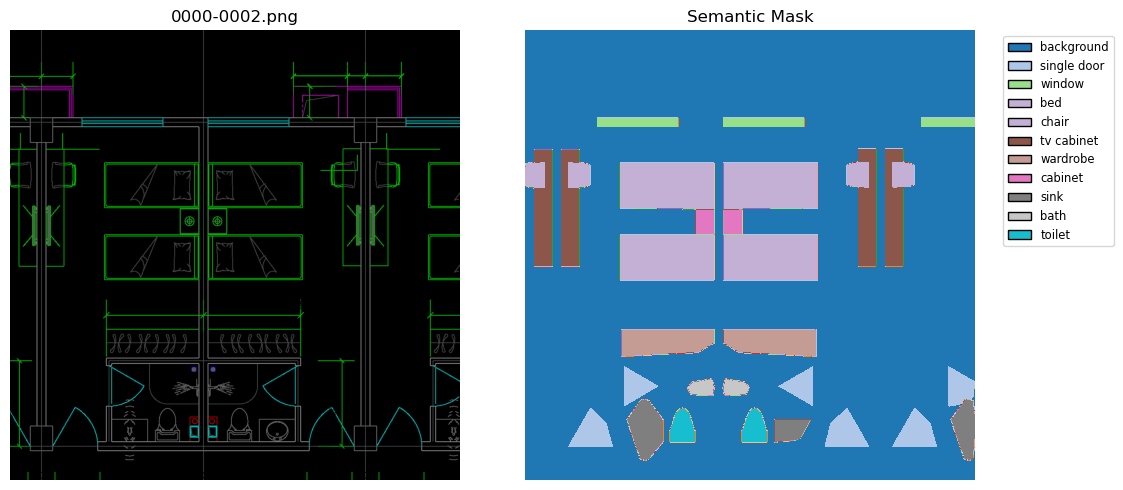

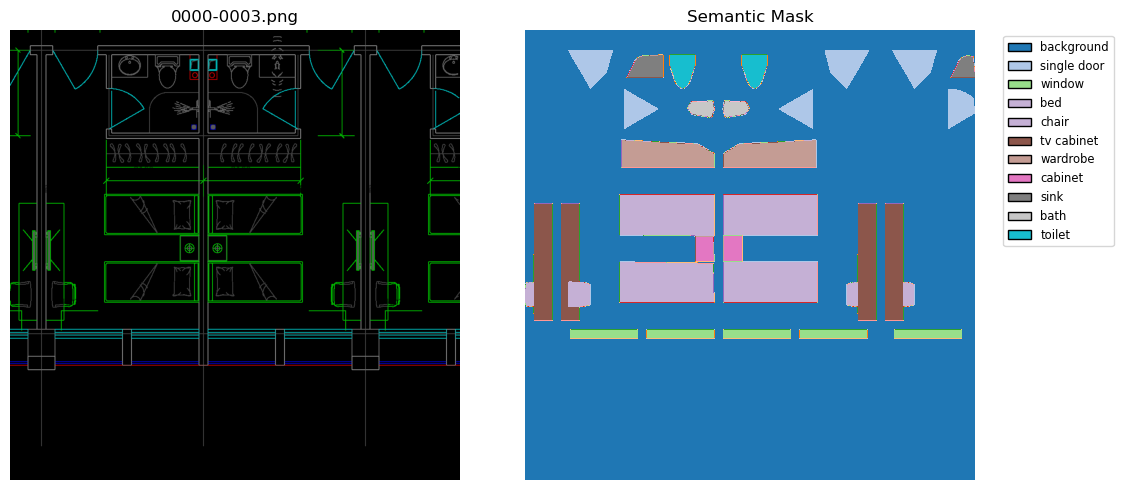

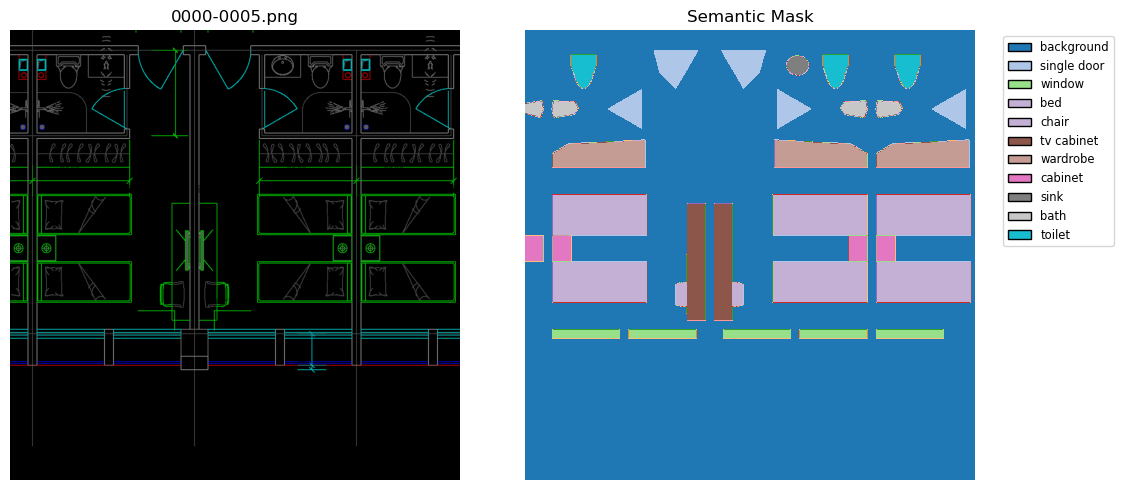

In [5]:
# --- 3) Visualize a few samples with legend ---
cmap = plt.get_cmap("tab20", NUM_CLASSES)
mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*_label.png")))[:N_DISPLAY]

for mask_path in mask_paths:
    basefn   = os.path.basename(mask_path).replace("_label.png", ".png")
    img      = cv2.cvtColor(cv2.imread(os.path.join(img_dir, basefn)), cv2.COLOR_BGR2RGB)
    mask     = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(img); ax1.axis("off"); ax1.set_title(basefn)
    im = ax2.imshow(mask, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1)
    ax2.axis("off"); ax2.set_title("Semantic Mask")

    # legend for present classes
    unique_ids = np.unique(mask)
    patches = [Patch(facecolor=cmap(uid), edgecolor='k', label=CAT_NAMES.get(uid, str(uid)))
               for uid in unique_ids if uid in CAT_NAMES]
    ax2.legend(handles=patches, bbox_to_anchor=(1.05,1), loc="upper left", fontsize="small")

    plt.tight_layout()
    plt.show()